# Load data from Huggingface

In [2]:
#!pip install python-dotenv huggingface_hub datasets matplotlib transformers scikit-learn numpy gensim

In [5]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# environment
load_dotenv(override=True)

# Get the HF token from environment variables
hf_token = os.getenv('HF_TOKEN')

# Log in to Hugging Face
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
# Load in our dataset
rawdata = load_dataset("cogsci13/Amazon-Reviews-2023-Books-Meta", split="full", trust_remote_code=True)
# print(dataset[0])

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'cogsci13/Amazon-Reviews-2023-Books-Meta' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


# Data Exploration

In [6]:
len(rawdata)

4448181

In [7]:
print(rawdata[0])

{'main_category': 'Books', 'title': 'Chaucer', 'average_rating': 4.5, 'rating_number': 29, 'features': [], 'description': [], 'price': '8.23', 'images': {'hi_res': [None], 'large': ['https://m.media-amazon.com/images/I/41X61VPJYKL._SX334_BO1,204,203,200_.jpg'], 'thumb': [None], 'variant': ['MAIN']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'Peter Ackroyd (Author)', 'categories': ['Books', 'Literature & Fiction', 'History & Criticism'], 'details': '{"Publisher": "Chatto & Windus; First Edition (January 1, 2004)", "Language": "English", "Hardcover": "196 pages", "ISBN 10": "0701169850", "ISBN 13": "978-0701169855", "Item Weight": "10.1 ounces", "Dimensions": "5.39 x 0.71 x 7.48 inches"}', 'parent_asin': '0701169850', 'bought_together': None, 'subtitle': 'Hardcover – Import, January 1, 2004', 'author': "{'avatar': 'https://m.media-amazon.com/images/I/21Je2zja9pL._SY600_.jpg', 'name': 'Peter Ackroyd', 'about': ['Peter Ackroyd, (born 5 October 1949) is an English biograph

In [8]:
# Investigate a particular datapoint
datapoint = rawdata[1]
datapoint

{'main_category': 'Books',
 'title': 'Notes from a Kidwatcher',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Contains 23 selected articles by this influential writer, researcher, educator, and speaker. They're grouped around six major themes inherent in teacher education: culture and community; miscue analysis, reading strategies and comprehension; print awareness and the roots of literacy; the writing process; kidwatching; and whole language theory. No index. Annotation c. by Book News, Inc., Portland, Or."],
 'description': ['About the Author',
  "SANDRA WILDE, Ph.D., is widely recognized for her expertise in developmental spelling and her advocacy of holistic approaches to spelling and phonics. She is Professor of Curriculum and Instruction at Portland State University in Oregon. She is best known for her work in invented spelling, phonics and miscue analysis. She specializes in showing teachers how kids' invented spellings and miscues can help us work with them in mo

In [9]:
# Investigate
datapoint = rawdata[5]
print(f"title:{datapoint['title']}")
print(f"description:{datapoint['description']}")
print(f"features:{datapoint['features']}")
print(f"details:{datapoint['details']}")
print(f"price:{datapoint['price']}")

title:Writings from a Black Woman Living in the Land of the "Free": Strength, Power, Resilience
description:[]
features:["Take a step into the modern perspective of a young black woman living in America. Tori Ruff explores the injustices and pain endured by the African American community for centuries. Through a series of writings, she speaks on topics including police brutality, racism, and discrimination. 'Writings from a Black Woman Living in the Land of the Free' takes readers on a journey of empathy and a sense of empowerment."]
details:{"Publisher": "Independently published (December 30, 2021)", "Language": "English", "Paperback": "24 pages", "ISBN 13": "979-8528537702", "Item Weight": "3.2 ounces", "Dimensions": "7 x 0.06 x 9 inches"}
price:4.05


In [10]:
# Xem có bao datapoint có price trong dataset

prices = 0
for datapoint in rawdata:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"Có {prices} điểm dữ liệu có giá chiếm {prices/len(rawdata)*100:,.1f}%")

Có 3286798 điểm dữ liệu có giá chiếm 73.9%


In [8]:
# Lọc dữ liệu, sử dụng filter sẽ trả về đối tượng Dataset thay vì generator
# Lọc những records có prices
# dp trong rawdata phải có trường price
# giá trị của trường price phải là str (isinstance để kiểm tra kiểu dữ liệu của đối tượng)
# giá trị của price khi bỏ dấu '.' phải là chuỗi chỉ chứa số (hợp lệ)
# giá trị của số price > 0
# filtered = (dp for dp in rawdata if "price" in dp and isinstance(dp["price"], str) and dp["price"].replace('.', '', 1).isdigit() and float(dp["price"]) > 0)
filtered = rawdata.filter(
    lambda dp: "price" in dp and isinstance(dp["price"], str) and dp["price"].replace('.', '', 1).isdigit() and float(dp["price"]) > 0
)

In [10]:
# Lấy mẫu ngẫu nhiên 100k records từ filtered
shuffled = filtered.shuffle(seed=42)
dataset = shuffled.select(range(100000))
print(f"Loaded {len(dataset):,} examples with prices")

Loaded 100,000 examples with prices


In [12]:
# Mô hình dự đoán giá sách dựa trên mô tả sản phẩm nên cần hiểu phân bổ độ dài văn bản
prices = []
lengths = []

for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        if price > 0:
            prices.append(price)
            contents = (
                datapoint['title'] +
                str(datapoint.get("description", "")) +
                str(datapoint.get("features", "")) +
                str(datapoint.get("details", ""))
            )
            lengths.append(len(contents))
    except ValueError as e:
        pass

len(lengths)

100000

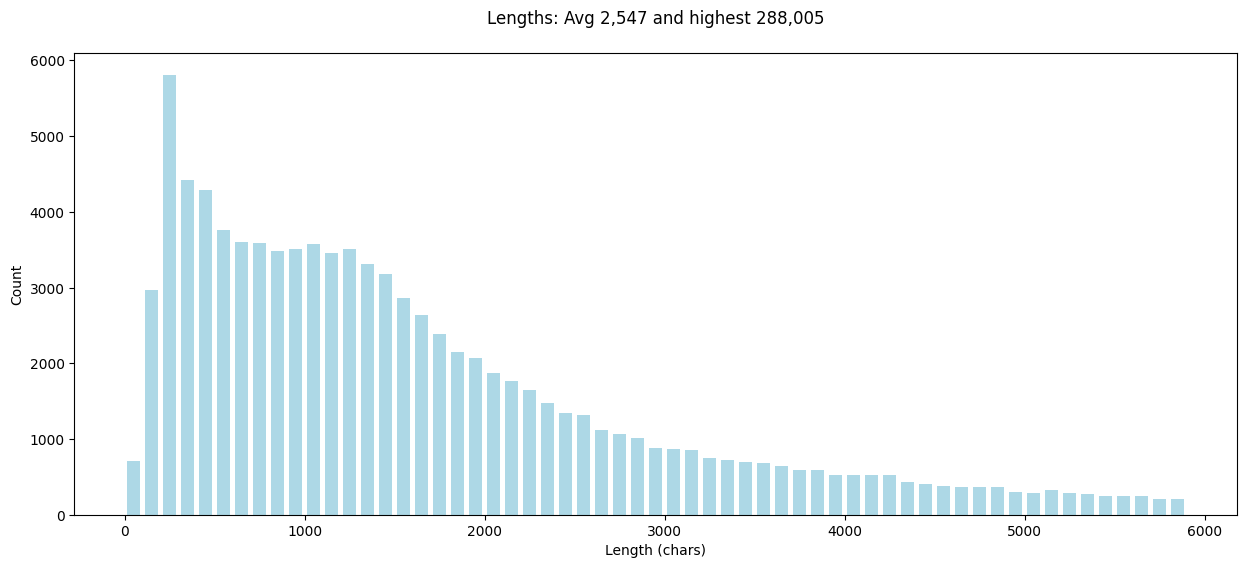

In [13]:
# Plot lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')

plt.hist(lengths, rwidth=0.7, color='lightblue', bins=range(0, 6000, 100))
plt.show()

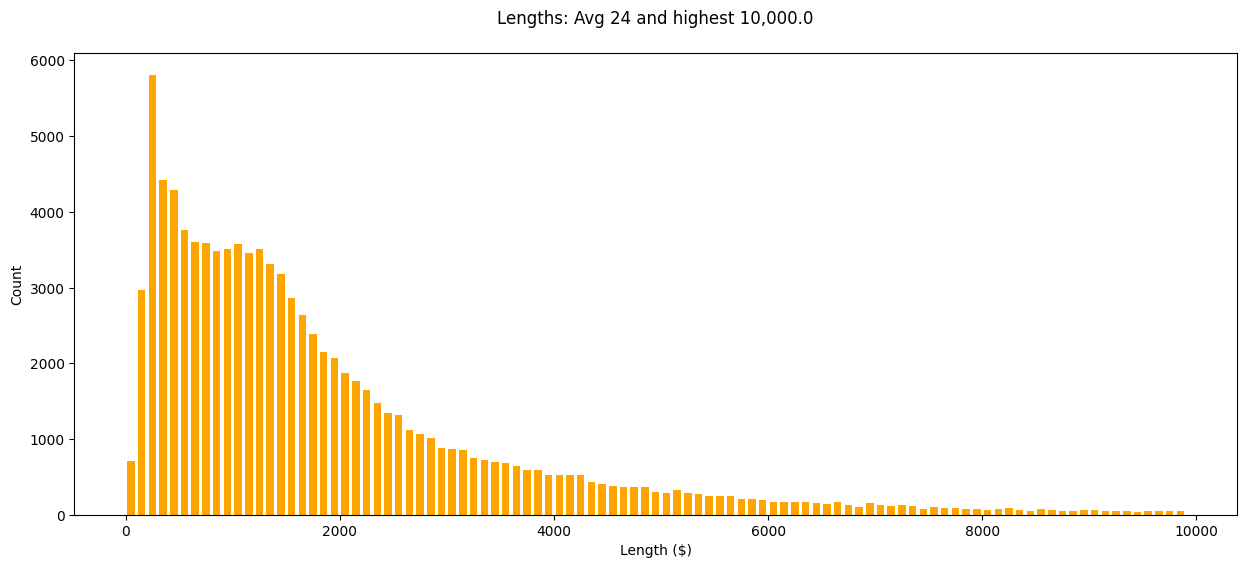

In [14]:
# Plot prices
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(prices)/len(prices):,.0f} and highest {max(prices):,}\n")
plt.xlabel('Length ($)')
plt.ylabel('Count')

plt.hist(lengths, rwidth=0.7, color='orange', bins=range(0, 10000, 100))
plt.show()

Dựa vào biểu đồ có thể thấy dữ liệu bị lệch (right-skewed distribution)

# Data Transform

4 bước transform:
- Data clean: --> Loại bỏ thông tin không liên quan
- Tokenization: Chuyển text thành tokens
- Data quality: --> Giữ những dữ liệu có ích
- Prompt standardization: --> format promt "How much ... the book is ...price is $?"

In [15]:
"""Trước hết, cần phải giới hạn lại số lượng tokens
- Nếu số lượng tokens quá nhỏ mô hình có thể không học được
- Nếu số lượng tokens quá lớn, sẽ tốn chi phí xử lý và mô hình có thể không chạy do giới hạn về phần cứng (cpu, gpu)"""
from transformers import AutoTokenizer
import re

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150
MAX_TOKENS = 160
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

In [16]:
def clean_text(text: str) -> str:
    """Remove unnecessary characters"""
    # Loại bỏ những ký tự không cần thiết
    text = re.sub(r'[:\[\]"{} 【】 \s]+', ' ', text).strip()
    text = text.replace(" ,", ",").replace(",,,",",").replace(",,",",")
    words = text.split(' ')
    # Loại bỏ các ký tự có khả năng là mã sản phẩm trong mô tả
    select = [word for word in words if (len(word) < 7) or (not any(char.isdigit() for char in word))]
    return " ".join(select)

In [17]:
text = '[123456M123] Writing from a Black Woman Living in the Land of the "Free": Strength, Power, Resilience'
cleaned = clean_text(text)
print(cleaned)

Writing from a Black Woman Living in the Land of the Free Strength, Power, Resilience


In [18]:
from BookItems import BookItem

B:\ai\finetunellm-amazon-books\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vmt\.cache\huggingface\hub\models--meta-llama--Meta-Llama-3.1-8B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [19]:
book_items = []
for datapoint in dataset:
    try:
        price = float(datapoint['price'])
        book_item = BookItem(datapoint, price)
        if book_item.include:
            book_items.append(book_item)
    except ValueError as e:
        pass

In [20]:
print(f"There are {len(book_items):,} books")

There are 82,675 books


In [23]:
print(book_items[0].title)
print(book_items[0].price)
print(book_items[0].category)

New Moms Need New Swear Words!: A Fun New Coloring Book!
13.78
Books


In [24]:
book_items[0].prompt

"How much does this book cost to the nearest dollar?\n\nNew Moms Need New Swear Words! A Fun New Coloring Book!\nStress relieving coloring book full of HILARIOUS alternative swear words!! Trying not to curse in front of your children isn't easy! This awesome new coloring book gives alternative swear words for you to use that won't upset the kids! Trying not to curse in front of your children isn't easy! This awesome new coloring book gives alternative swear words for you to use that won't upset the kids! Publisher CreateSpace Independent Publishing Platform (June 24, 2016), Language English, Paperback 40 pages, ISBN 10 ISBN 13 Item Weight 8 ounces, Dimensions 8.5 x 0.1 x 11 inches Categories Books, Parenting & Relationships, Family Relationships Author 'avatar' '\n\nPrice is $14.00"

In [25]:
book_items[0].test_prompt()

"How much does this book cost to the nearest dollar?\n\nNew Moms Need New Swear Words! A Fun New Coloring Book!\nStress relieving coloring book full of HILARIOUS alternative swear words!! Trying not to curse in front of your children isn't easy! This awesome new coloring book gives alternative swear words for you to use that won't upset the kids! Trying not to curse in front of your children isn't easy! This awesome new coloring book gives alternative swear words for you to use that won't upset the kids! Publisher CreateSpace Independent Publishing Platform (June 24, 2016), Language English, Paperback 40 pages, ISBN 10 ISBN 13 Item Weight 8 ounces, Dimensions 8.5 x 0.1 x 11 inches Categories Books, Parenting & Relationships, Family Relationships Author 'avatar' '\n\nPrice is $"

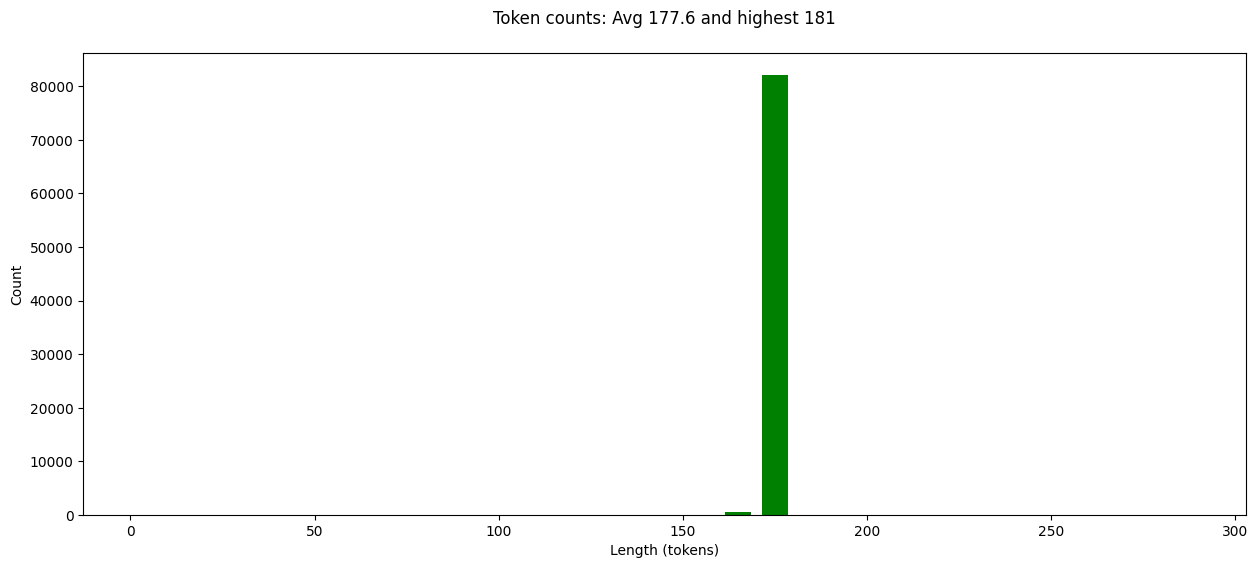

In [26]:
# Phân bổ số lượng token của từng item
tokens = [item.token_count for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color='green', bins=range(0, 300, 10))
plt.show()

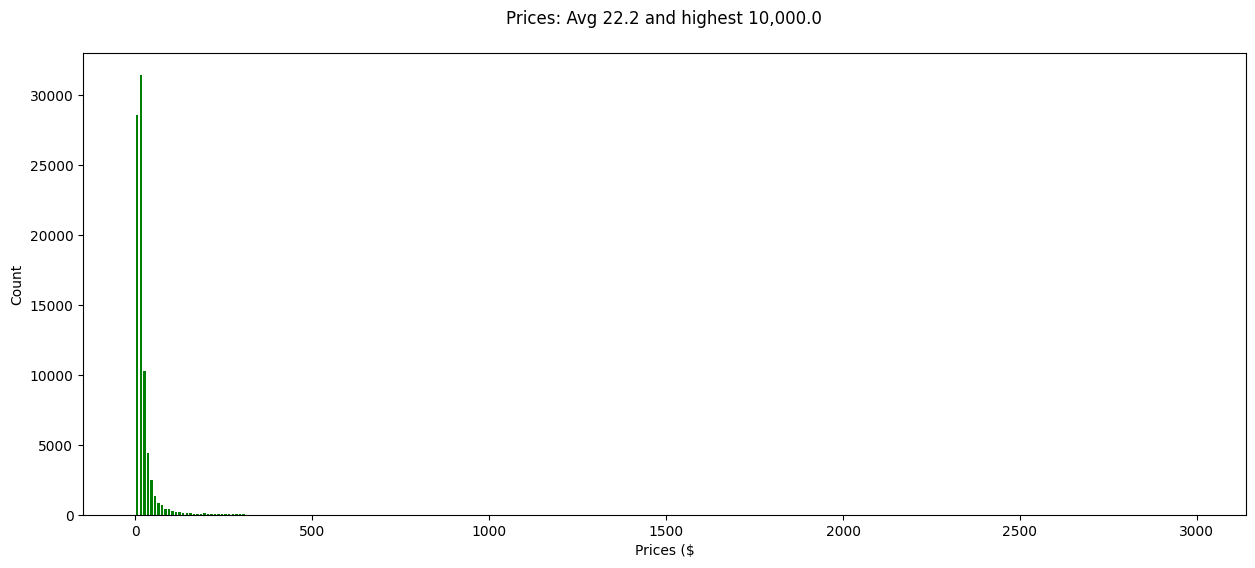

In [30]:
# Phân bổ mức giá
prices = [item.price for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Prices ($')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color='green', bins=range(0, 3000, 10))
plt.show()

Dựa trên biểu đồ có thể thấy sau khi lọc, mức giá của các đầu sách phân bổ rất lệch (imbalance). Những sách có giá khoảng 0-300$ rất nhiều trong khi những sách có giá cao hơn rất ít.
Việc phân bổ bị lệch như này có thể làm mô hình thiên vị (bias) khi đưa dữ liệu vào để huấn luyện.
--> Cần tìm cách để xử lý dữ l

# Bring my raw data

In [31]:
from BookLoader import load_books_from_rawdata

book_items = load_books_from_rawdata(rawdata, workers=8)
print(f"✅ A grand total of {len(book_items):,} books")

100%|██████████| 4449/4449 [13:51<00:00,  5.35it/s]


✅ A grand total of 2,720,123 books


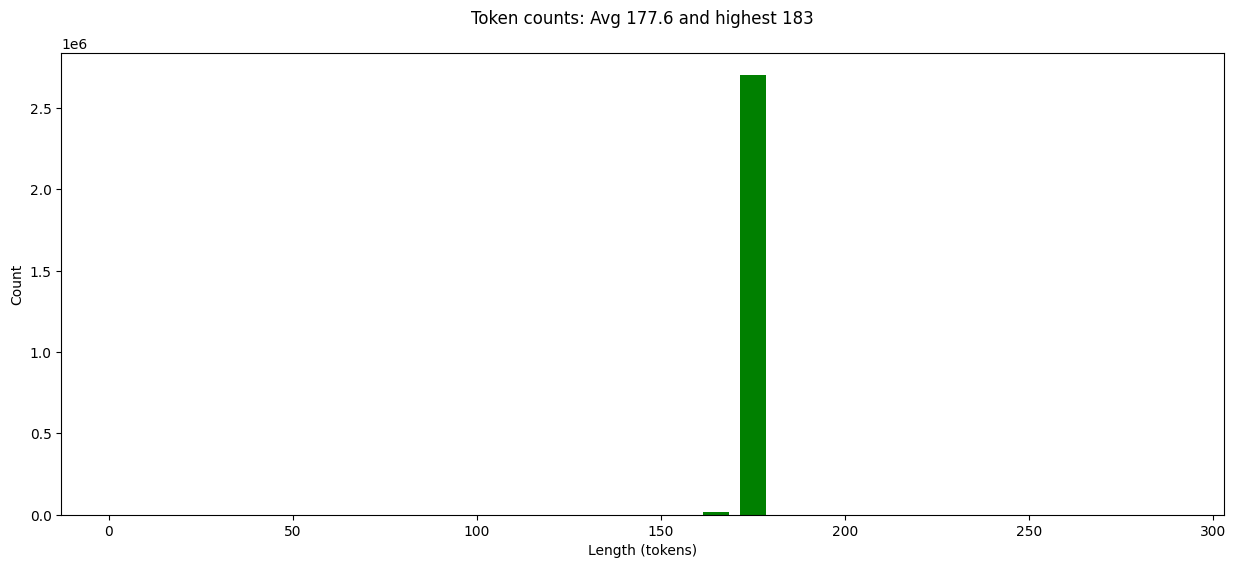

In [33]:
# Plot the distribution of token counts

tokens = [item.token_count for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

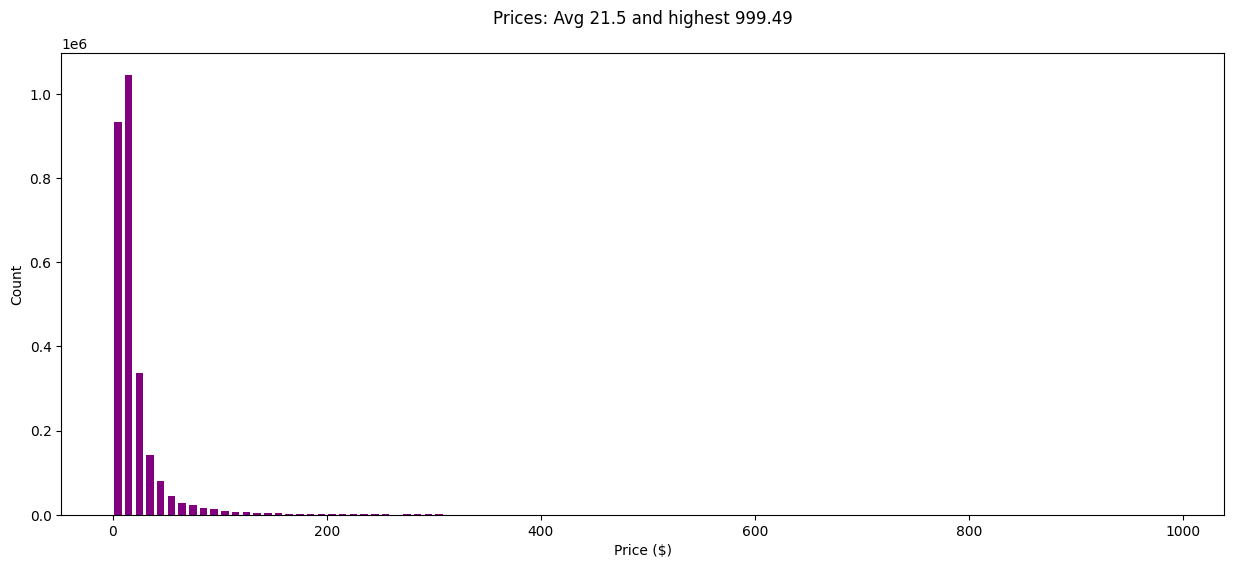

In [48]:
# Plot the distribution of prices

prices = [item.price for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 1000, 10))
plt.show()

## sort data for more balance

In [56]:
from collections import defaultdict
import numpy as np
import random

# Step 1: Create a dict to hold items bucketed by rounded price
price_buckets = defaultdict(list)
for item in book_items:
    rounded_price = round(item.price)
    price_buckets[rounded_price].append(item)

# Step 2: Set random seeds for reproducibility
np.random.seed(123)
random.seed(123)

# Step 3: Sample from each bucket based on your logic
sample = []
for price in range(1, 1000):
    bucket = price_buckets[price]

    if price >= 50:
        sample.extend(bucket)
    elif len(bucket) <= 2000:
        sample.extend(bucket)
    else:
        selected_indices = np.random.choice(len(bucket), size=2000, replace=False)
        selected = [bucket[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 289,972 items in the sample


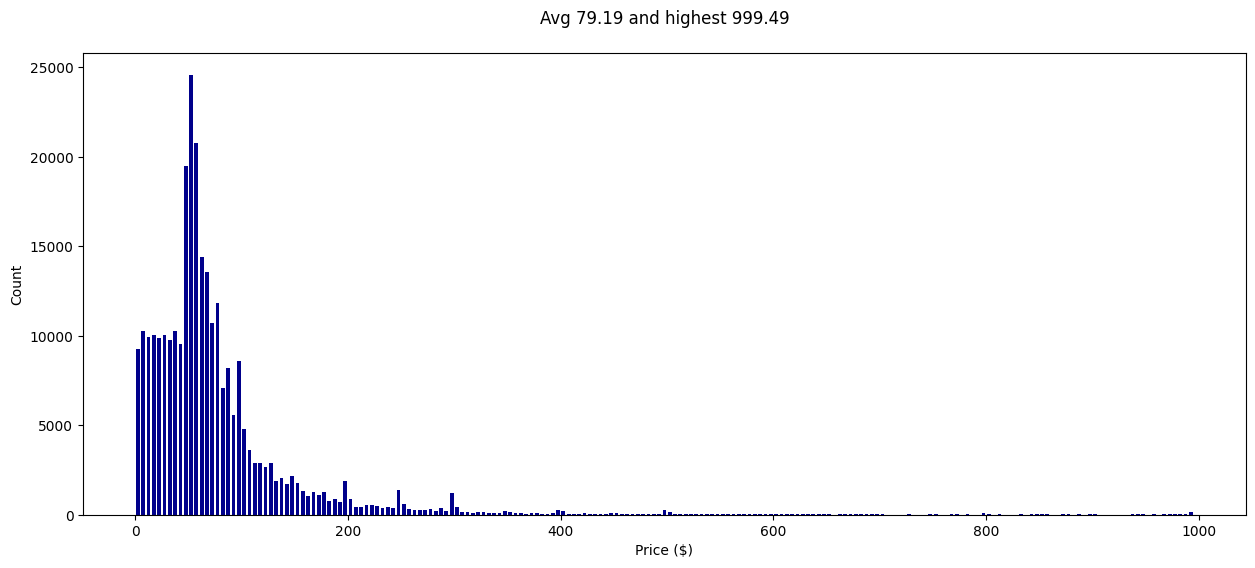

In [57]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 5))
plt.show()

Chiến lược lấy mẫu này vẫn giữ được hình dạng phân phối và giảm độ mất cân bằng dữ liệu --> khá hiệu quả

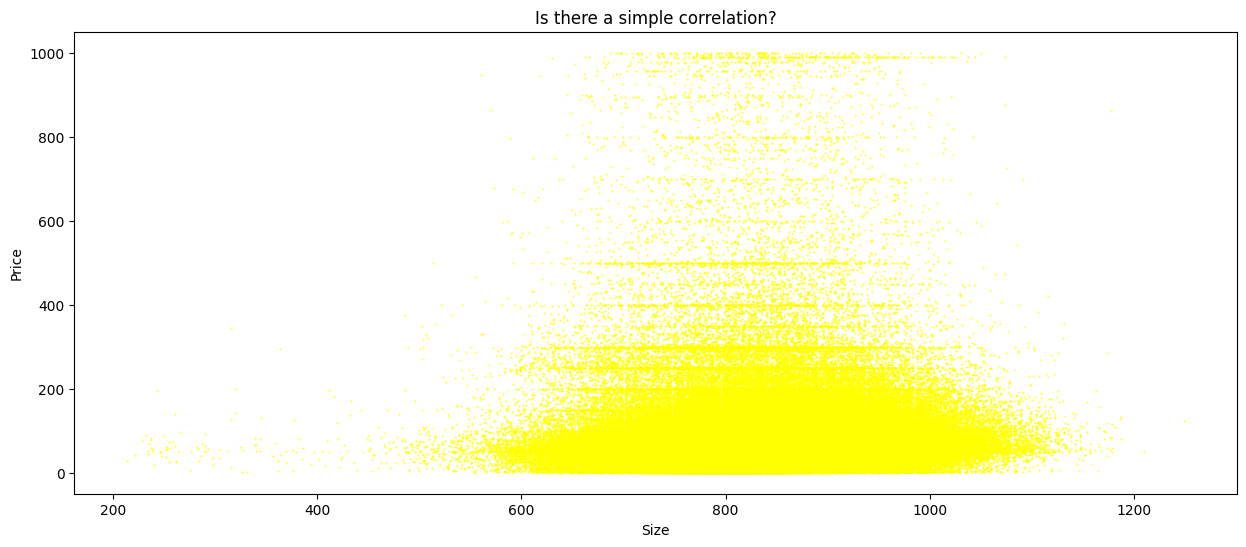

In [58]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(sizes, prices, s=0.2, color="yellow")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

# Split data

In [59]:
random.seed(123)

# Shuffle full dataset
random.shuffle(sample)

# Calculate split index
split_idx = int(0.9 * len(sample))  # 90% training

# Split into training and test sets
train = sample[:split_idx]
test = sample[split_idx:]

# Print result
print(f"Divided into a training set of {len(train):,} items and a test set of {len(test):,} items")

Divided into a training set of 260,974 items and a test set of 28,998 items


In [60]:
print(train[0].prompt)

How much does this book cost to the nearest dollar?

Extremely Weird Animal Defenses
Describes the physical characteristics and behavior of a number of animals with unusual means of defense, including the burrfish, the gelada, and the bulldog ant Publisher Rick Steves (April 16, 1997), Language English, Paperback 32 pages, ISBN 10 ISBN 13 Reading age 8 - 12 years, Grade level 3 - 7, Item Weight 4.8 ounces, Dimensions 8.5 x 0.25 x 11.5 inches Categories Books, Science & Math, Biological Sciences Author 'avatar' 'https 'name' 'Sarah Lovett', 'about' 'Discover more of the author’s books, see similar authors, read author blogs and more'

Price is $3.00


In [61]:
print(test[0].test_prompt())

How much does this book cost to the nearest dollar?

Successful with the Agile Spotify Framework Squads, Tribes and Chapters - The Next Step After Scrum and Kanban?
The so called Spotify Framework, unlike frameworks or methods of the kind of Scrum, Kanban, Less, Nexus, SAFe, DSDM (or whatever the agile evergreens might all be called) is not a template that an organization can copy and implement. It is an example of a very successful approach to the topic Agile Product Development and is intended to encourage people to think and develop on their own. That is exactly what the experienced agile consultant and coach Alvar Lundberg does in his book. He shows the elements of the Spotify framework, explains its background and shows the reader how he can approach his own agile implementation based on these considerations and insights. He does not

Price is $


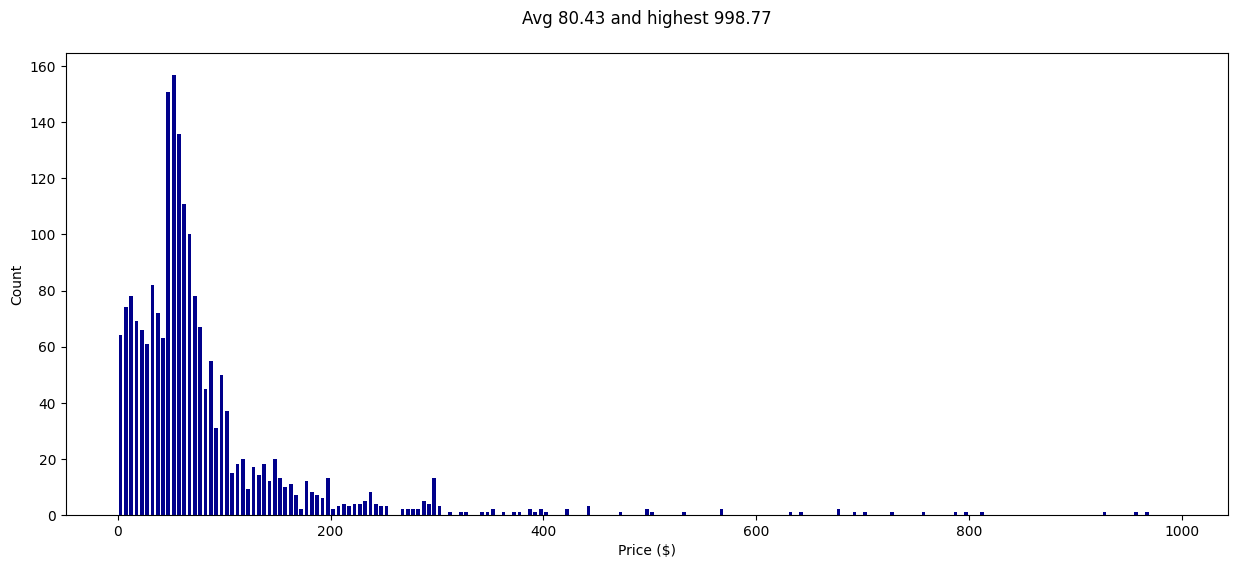

In [62]:
# Plot the distribution of prices in the first 2000 test points

prices = [float(item.price) for item in test[:2000]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 5))
plt.show()

# Upload dataset to huggingface hub

In [63]:
# extract prompt and price
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]

test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [64]:
# Hugging face dataset
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
# bunddle
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [65]:
# upload to hugging face hub
HF_USER = "vmt311"
DATASET_NAME = f"{HF_USER}/bookpricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:06<00:00,  6.81s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/vmt311/bookpricer-data/commit/981cce6c209a65237e298b3cd95e8c7b6d680a9a', commit_message='Upload dataset', commit_description='', oid='981cce6c209a65237e298b3cd95e8c7b6d680a9a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/vmt311/bookpricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='vmt311/bookpricer-data'), pr_revision=None, pr_num=None)

In [66]:
# write .pkl file for reuse
import pickle

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

In [67]:
# open .pkl files from local
import pickle

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)